In [1]:
import pandas as pd
import numpy as np

# average data

In [71]:


def process_metric_tables(metric_tables):
    def parse_tables_manual(metric_tables):
        dataframes = []
        for table in metric_tables:
            lines = table.strip().split('\n')
            headers = lines[0].split(maxsplit=2)
            data = []
            for line in lines[1:]:
                index_space = line.index(' ')
                first_split = line[:index_space].strip()
                remaining = line[index_space:].strip()
                parts = remaining.rsplit(maxsplit=2)
                if len(parts) == 3:
                    data.append([parts[0], parts[1], parts[2]])
                else:
                    data.append([parts[0], np.nan, np.nan])
            df = pd.DataFrame(data, columns=headers)
            df[headers[1]] = pd.to_numeric(df[headers[1]], errors='coerce')
            df[headers[2]] = pd.to_numeric(df[headers[2]], errors='coerce')
            dataframes.append(df)
        return dataframes

    def calculate_statistics_ordered(dataframes):
        metrics = dataframes[0]['Metric']
        result_list = []
        for metric in metrics:
            metric_data = [df[df['Metric'] == metric] for df in dataframes]
            metric_stats = {}
            for col in ['Training', 'Validation']:
                valid_data = pd.concat([md[col] for md in metric_data]).dropna()
                if not valid_data.empty:
                    mean_val = valid_data.mean()
                    std_val = valid_data.std()
                    metric_stats[col] = (mean_val, std_val)
                else:
                    metric_stats[col] = np.nan
            result_list.append((metric, metric_stats))
        return result_list

    def format_output_ordered(statistics_ordered):
        output_df = pd.DataFrame(columns=['Metric', 'Training', 'Validation'])
        for metric, values in statistics_ordered:
            row = {'Metric': metric}
            for col in ['Training', 'Validation']:
                if col in values and not pd.isna(values[col]):
                    row[col] = f"({values[col][0]:.3f}, {values[col][1]:.3f})"
                else:
                    row[col] = np.nan
            output_df = pd.concat([output_df, pd.DataFrame([row])], ignore_index=True)
        output_string = output_df.to_string(index=False)
        return output_string

    # Process the input tables
    dataframes = parse_tables_manual(metric_tables)
    statistics = calculate_statistics_ordered(dataframes)
    output_table = format_output_ordered(statistics)
    return output_table
# Example usage
metric_tables = [
    """                              Metric  Training  Validation
0                   Average Accuracy     0.854       0.694
1     Standard Deviation of Accuracy     0.205       0.137
2                      Best Accuracy     0.997       0.797
3                      Last Accuracy     0.991       0.756
4                        Overall AUC       NaN       0.483
5                   Maximum F1 Score       NaN       0.800
6                       Minimum Loss       NaN       0.955
7  Difference in Average Loss Last N       NaN       2.005
8  Standard Deviation of Loss Last N       NaN       0.256""",


"""                              Metric  Training  Validation
0                   Average Accuracy     0.876       0.702
1     Standard Deviation of Accuracy     0.150       0.089
2                      Best Accuracy     0.993       0.776
3                      Last Accuracy     0.993       0.776
4                        Overall AUC       NaN       0.495
5                   Maximum F1 Score       NaN       0.776
6                       Minimum Loss       NaN       0.918
7  Difference in Average Loss Last N       NaN       1.981
8  Standard Deviation of Loss Last N       NaN       0.201""",


"""                              Metric  Training  Validation
0                   Average Accuracy     0.848       0.704
1     Standard Deviation of Accuracy     0.199       0.122
2                      Best Accuracy     0.995       0.789
3                      Last Accuracy     0.957       0.732
4                        Overall AUC       NaN       0.502
5                   Maximum F1 Score       NaN       0.793
6                       Minimum Loss       NaN       0.929
7  Difference in Average Loss Last N       NaN       2.368
8  Standard Deviation of Loss Last N       NaN       0.418""", 

"""                              Metric  Training  Validation
0                   Average Accuracy     0.730       0.625
1     Standard Deviation of Accuracy     0.267       0.183
2                      Best Accuracy     0.980       0.832
3                      Last Accuracy     0.980       0.832
4                        Overall AUC       NaN       0.513
5                   Maximum F1 Score       NaN       0.832
6                       Minimum Loss       NaN       0.962
7  Difference in Average Loss Last N       NaN       1.513
8  Standard Deviation of Loss Last N       NaN       0.290""",

"""                              Metric  Training  Validation
0                   Average Accuracy     0.818       0.641
1     Standard Deviation of Accuracy     0.231       0.132
2                      Best Accuracy     0.995       0.748
3                      Last Accuracy     0.995       0.724
4                        Overall AUC       NaN       0.523
5                   Maximum F1 Score       NaN       0.743
6                       Minimum Loss       NaN       1.036
7  Difference in Average Loss Last N       NaN       2.599
8  Standard Deviation of Loss Last N       NaN       0.495"""



    # More tables would follow here
]

result = process_metric_tables(metric_tables)
print(result)


                           Metric       Training     Validation
                 Average Accuracy (0.825, 0.057) (0.673, 0.037)
   Standard Deviation of Accuracy (0.210, 0.043) (0.133, 0.034)
                    Best Accuracy (0.992, 0.007) (0.788, 0.031)
                    Last Accuracy (0.983, 0.016) (0.764, 0.043)
                      Overall AUC            NaN (0.503, 0.016)
                 Maximum F1 Score            NaN (0.789, 0.033)
                     Minimum Loss            NaN (0.960, 0.046)
Difference in Average Loss Last N            NaN (2.093, 0.415)
Standard Deviation of Loss Last N            NaN (0.332, 0.121)


# Manipulate Data

In [83]:
import re
import csv

def parse_metric_from_table(table, metric_name):
    """
    Parses a specified metric and its values from a string representation of a table.
    
    Parameters:
    - table (str): Multi-line string containing the table of metrics.
    - metric_name (str): Name of the metric to parse (e.g., 'Overall AUC', 'Best Accuracy').
    
    Returns:
    - Tuple[float, float]: (value_standard, value_augmented) from the Training and Validation columns if available.
    """
    pattern = re.compile(rf"{re.escape(metric_name)}\s+.*?\s+\((\d+\.\d+),\s*\d+\.\d+\)")
    match = pattern.search(table)
    if match:
        return (None, float(match.group(1)))  # Only validation values are returned, as training values are not needed
    return (None, None)

def calculate_percentage_increase(standard, augmented):
    """
    Calculates the percentage increase from the standard dataset to the augmented dataset.
    
    Parameters:
    - standard (float): Metric value from the standard dataset.
    - augmented (float): Metric value from the augmented dataset.
    
    Returns:
    - float: Percentage increase of the metric, rounded to three decimal places.
    """
    if standard is not None and augmented is not None and standard != 0:
        return round(((augmented - standard) / standard) * 100, 3)
    return None

def write_results_to_csv(path, method, weather, percentage_auc, percentage_accuracy, percentage_f2):
    """
    Writes the calculated results to a CSV file.
    
    Parameters:
    - method (str): Description of the method (e.g., "Standard", "Augmented").
    - weather (str): Description of the weather condition (e.g., "Sunny", "Cloudy").
    - type_ (str): Type of data or experiment (e.g., "Simulation", "Real-World").
    - percentage_auc (float): Calculated percentage increase for AUC.
    - percentage_accuracy (float): Calculated percentage increase for Best Accuracy.
    """
    
    with open(path, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([method, weather, percentage_auc, percentage_accuracy, percentage_f2])


# Example string tables
table1 = """                           Metric       Training     Validation
                 Average Accuracy (0.591, 0.060) (0.549, 0.049)
   Standard Deviation of Accuracy (0.198, 0.015) (0.148, 0.017)
                    Best Accuracy (0.881, 0.024) (0.760, 0.051)
                    Last Accuracy (0.866, 0.031) (0.741, 0.038)
                      Overall AUC            NaN (0.503, 0.025)
                 Maximum F1 Score            NaN (0.744, 0.049)
                     Minimum Loss            NaN (0.900, 0.084)
Difference in Average Loss Last N            NaN (0.503, 0.192)
Standard Deviation of Loss Last N            NaN (0.106, 0.057)"""

table2 = """                           Metric       Training     Validation
                 Average Accuracy (0.853, 0.033) (0.697, 0.042)
   Standard Deviation of Accuracy (0.182, 0.036) (0.109, 0.036)
                    Best Accuracy (0.989, 0.006) (0.783, 0.019)
                    Last Accuracy (0.984, 0.010) (0.743, 0.017)
                      Overall AUC            NaN (0.514, 0.040)
                 Maximum F1 Score            NaN (0.783, 0.021)
                     Minimum Loss            NaN (0.874, 0.048)
Difference in Average Loss Last N            NaN (1.797, 0.362)
Standard Deviation of Loss Last N            NaN (0.301, 0.108)"""

# Use these functions to extract and calculate percentage increases
auc_values1 = parse_metric_from_table(table1, "Overall AUC")
auc_values2 = parse_metric_from_table(table2, "Overall AUC")

best_accuracy_values1 = parse_metric_from_table(table1, "Best Accuracy")
best_accuracy_values2 = parse_metric_from_table(table2, "Best Accuracy")

f1_values1 = parse_metric_from_table(table1, "Maximum F1 Score")
f1_values2 = parse_metric_from_table(table2, "Maximum F1 Score")

method = "he+c+rotate"
weather = "45"

percentage_increase_auc = calculate_percentage_increase(auc_values1[1], auc_values2[1])
percentage_increase_best_accuracy = calculate_percentage_increase(best_accuracy_values1[1], best_accuracy_values2[1])
percentage_increase_f2 = calculate_percentage_increase(f1_values1[1], f1_values2[1])

# Write to CSV
path = "../results/round7b/percent_increase7b.csv"

write_results_to_csv(path, method, weather, percentage_increase_auc, percentage_increase_best_accuracy, percentage_increase_f2)

print("% Increase AUC:", percentage_increase_auc)
print("% Increase Best Accuracy:", percentage_increase_best_accuracy)
print("% Increase Best F1:", percentage_increase_f2)

% Increase AUC: 2.187
% Increase Best Accuracy: 3.026
% Increase Best F1: 5.242


# Pots

Index(['method', 'weather', '%inc_auc', '%inc_best_accuracy', '%inc_max_f1'], dtype='object')


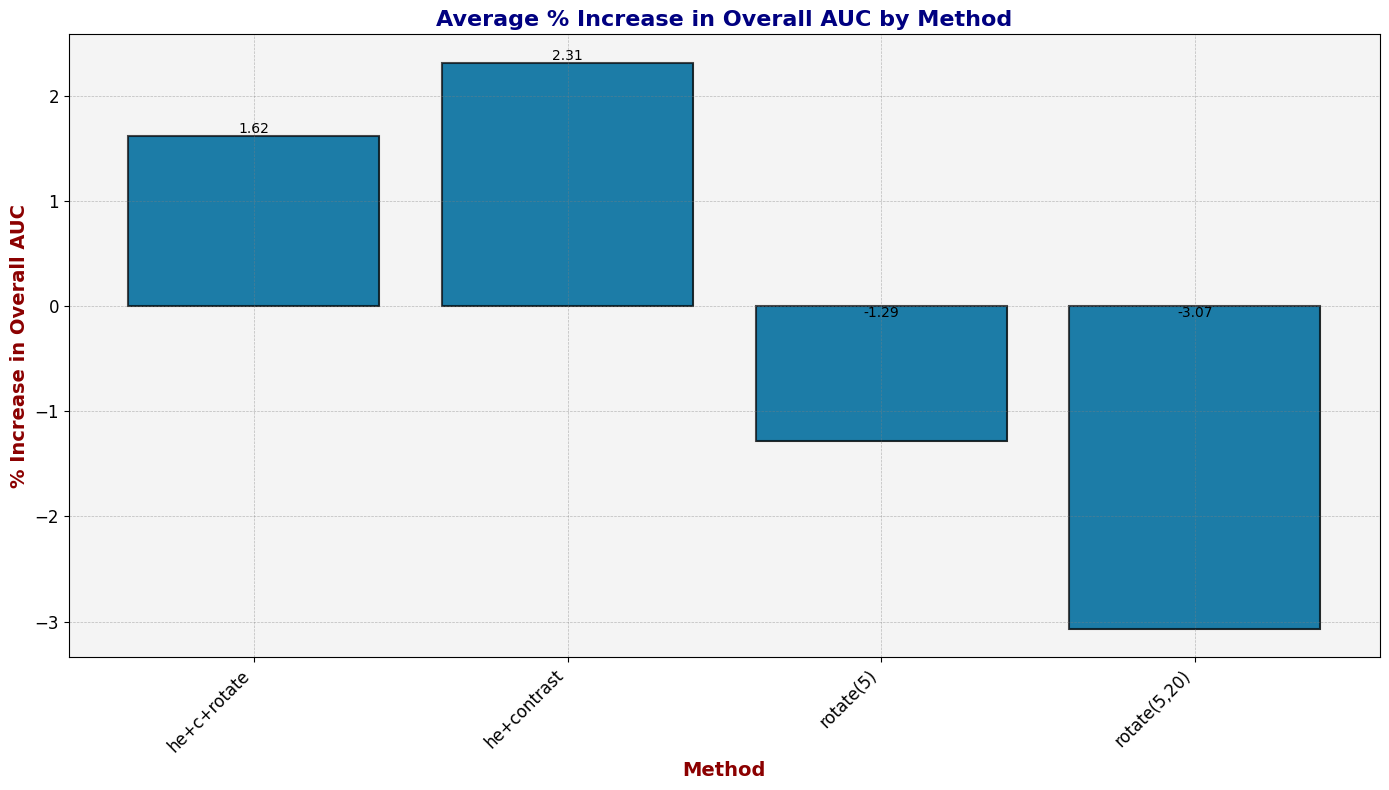

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(path)
print(df.columns)


method = 'Overall AUC'
method_path = 'auc'

# Simple plot example: Average % increase in AUC for each method
means = df.groupby('method')[f'%inc_{method_path}'].mean()


figures_path = "../results/round7b/figures/" 

# Styling
plt.figure(figsize=(14, 8))  # Adjust the figure size for better fit and visibility
plt.bar(means.index, means.values, color='teal', width=0.8, edgecolor='grey', linewidth=0.6, alpha=0.9)

# Adding rounded corners to bars
for bar in plt.bar(means.index, means.values):
    bar.set_edgecolor("k") # Black edges
    bar.set_linewidth(1.5)
    bar.set_alpha(0.7)  # Slight transparency

# Background and grid
plt.gca().set_facecolor('#f4f4f4')  # Light grey background
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Titles and labels with enhanced fonts
plt.title(f'Average % Increase in {method} by Method', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Method', fontsize=14, fontweight='bold', color='darkred')
plt.ylabel(f'% Increase in {method}', fontsize=14, fontweight='bold', color='darkred')

# Ticks and tick labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Text labels above bars
for index, value in enumerate(means):
    plt.text(index, value if value >= 0 else 0, f'{value:.2f}', ha='center', va='bottom' if value > 0 else 'top', fontsize=10, color='black')

plt.tight_layout()  # Adjust layout
plt.savefig(figures_path + f'average_increase_{method_path}.png')  # Save the figure to a file     
plt.show()


In [91]:
method = 'Overall Auc'
method_path = 'auc'

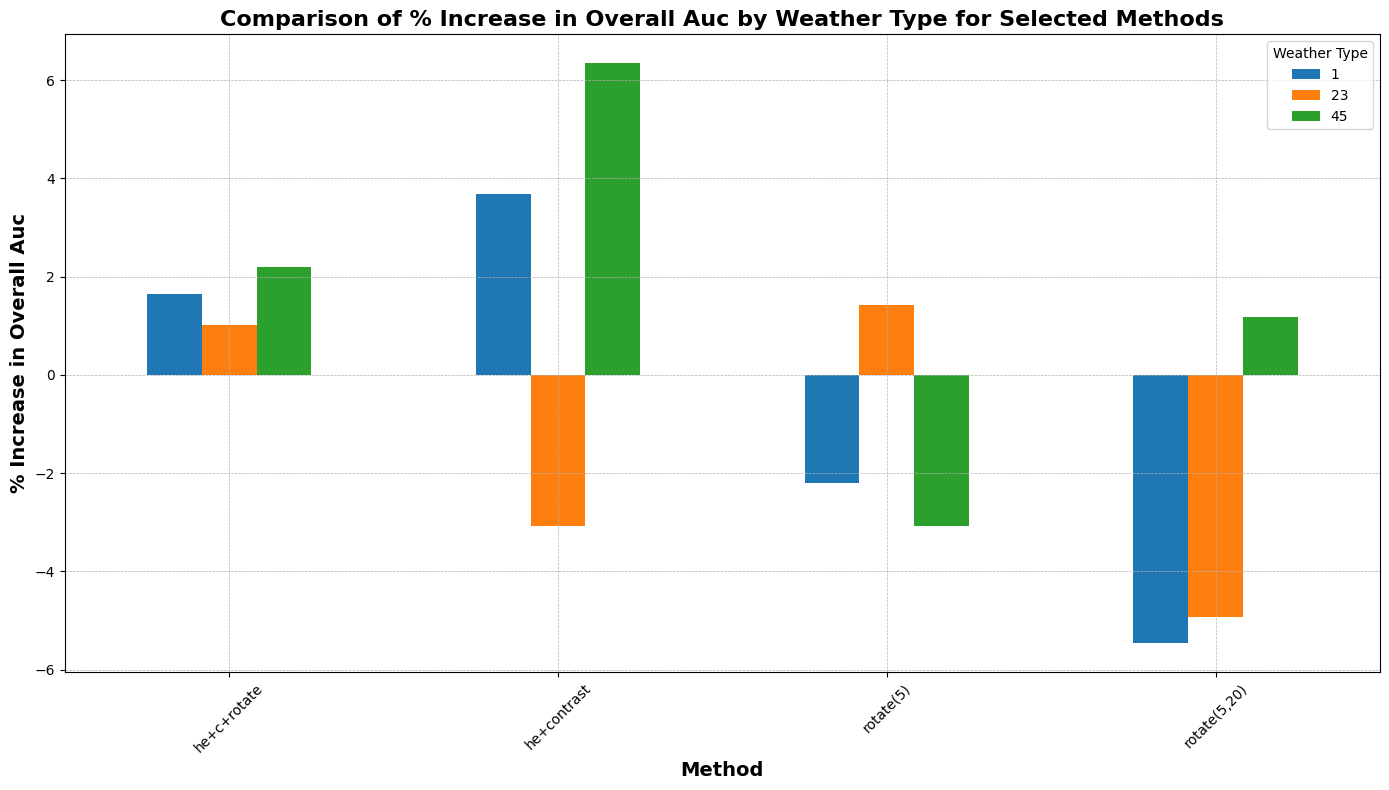

In [92]:
# Filter for selected methods
selected_methods = ['rotate(5)', 'rotate(20)', 'histeq', 'contrast(0.5)', 'guassian(1050)', 'gaussian(100200)']

# selected methods with all methods
selected_methods = df['method'].unique()

filtered_df = df[df['method'].isin(selected_methods)]


# Pivot data to get % increases for each weather type per method
pivot_df = filtered_df.pivot_table(index='method', columns='weather', values=f'%inc_{method_path}', aggfunc='mean')

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))
pivot_df.plot(kind='bar', ax=ax)

# Styling
ax.set_title(f'Comparison of % Increase in {method} by Weather Type for Selected Methods', fontsize=16, fontweight='bold')
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel(f'% Increase in {method}', fontsize=14, fontweight='bold')
ax.grid(True, which='major', linestyle='--', linewidth=0.5)
ax.legend(title='Weather Type')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(figures_path + f'comparison_increase_{method}_weather.png')
plt.show()